# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «{Censored}» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.shape

(354369, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
df.duplicated().sum()

4

In [7]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Предобработка данных

#### Преобразую типы данных:

In [8]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

#### Удалю строки с дубликатами:

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

#### Проверю пропущенные значения в "VehicleType":

In [11]:
df[df['VehicleType'].isna()].head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33


In [12]:
df[(df['Model'] == 'golf') & (df['Brand'] == 'volkswagen')]['VehicleType'].unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

In [13]:
df[(df['Model'] == 'golf') & (df['Brand'] == 'volkswagen')].groupby('VehicleType')['VehicleType'].count()

VehicleType
bus              760
convertible     1962
coupe            429
other            185
sedan          14744
small           3911
suv               25
wagon           3181
Name: VehicleType, dtype: int64

Что-то не так с данными по типу ТС, т.к. не бывает столько типов кузова у VW Golf (на других моделях тоже проверил). Не буду учитывать этот столбец при обучении.

#### Заполню пропуски в КП 'Gearbox':

In [14]:
df['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

Заполню пропуски модой по сгруппированным данным исходя из марки, модели.

Создам справочник: сгруппирую данные по марке и модели и найду для них моды.

In [15]:
gearbox_modes = df.groupby(['Brand','Model'])['Gearbox'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index()
gearbox_modes.head()

,Brand,Model,Gearbox
0,alfa_romeo,145,manual
1,alfa_romeo,147,manual
2,alfa_romeo,156,manual
3,alfa_romeo,159,manual
4,alfa_romeo,other,manual


Использую merge для заполнения пропущенных значений. Возможно, не все NaN заполнятся, т.к. не хватит данных в "справочнике" gearbox_modes:

In [16]:
df_mode = df.merge(gearbox_modes, how='left', on=['Brand','Model'], suffixes=('','_mode'))
x = df['Gearbox'].isna()
df.loc[x, 'Gearbox'] = df_mode.loc[x, 'Gearbox_mode']

In [17]:
print('Пропущено {:.0f} значений. '.format(df['Gearbox'].isna().sum()), 
      'Их доля: {:.1%}.'.format(df['Gearbox'].isna().sum() / df.shape[0]))

Пропущено 4131 значений.  Их доля: 1.2%.


Данных немного, поэтому удалю их:

In [18]:
df.dropna(subset=['Gearbox'], inplace=True)
df = df.reset_index()

In [19]:
df['Gearbox'].isna().sum()

0

#### Пропуски в моделе ТС 'Model':

In [21]:
df[df['Model'].isna()].head(3)

,index,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
59,59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
81,81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13


In [22]:
na_model_share = df['Model'].isna().sum() / df.shape[0]
print('Доля строк с пропусками в моделе: {:.1%}'.format(na_model_share))

Доля строк с пропусками в моделе: 4.4%


Так как разумного способа заполнить все пропущенные значения не видно, удалю эти строки, они занимают небольшую долю в датасете:

In [23]:
df.dropna(subset=['Model'], inplace=True)
df = df.reset_index()

#### Обработаю пропущенные значения в 'FuelType':

Довольно много наблюдений с пропусками в 'NotRapaired', так что удалять нельзя. Заполню пропуски модой.

Заполню пропуски модой по сгруппированным данным исходя из марки, мощности двигателя:

In [24]:
fuel_modes = df.groupby(['Brand','Power'])['FuelType'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index()
fuel_modes.head()

,Brand,Power,FuelType
0,alfa_romeo,0,petrol
1,alfa_romeo,50,petrol
2,alfa_romeo,63,petrol
3,alfa_romeo,65,petrol
4,alfa_romeo,66,petrol


Использую merge для заполнения пропущенных значений. Возможно, не все NaN заполнятся, т.к. не хватит данных в "справочнике" fuel_modes:

In [25]:
df_mode = df.merge(fuel_modes, how='left', on=['Brand','Power'], suffixes=('','_mode'))
x = df['FuelType'].isna()
df.loc[x, 'FuelType'] = df_mode.loc[x, 'FuelType_mode']

In [26]:
print('Пропущено {:.0f} значений. '.format(df['FuelType'].isna().sum()), 
      'Их доля: {:.1%}.'.format(df['FuelType'].isna().sum() / df.shape[0]))

Пропущено 0 значений.  Их доля: 0.0%.


Пропусков не осталось.

#### Обработаю пропущенные значения в 'NotRapaired':

In [27]:
print('Пропущено {:.0f} значений. '.format(df['NotRepaired'].isna().sum()), 
      'Их доля: {:.1%}.'.format(df['NotRepaired'].isna().sum() / df.shape[0]))

Пропущено 62100 значений.  Их доля: 18.6%.


In [28]:
df['NotRepaired'].value_counts()

no     238852
yes     33708
Name: NotRepaired, dtype: int64

Предположу, что если нет информации о ремонте, значит ТС не ремонтировалось. Следовательно, могу заполнить отсутствующие значения на "yes":

In [29]:
df['NotRepaired'].fillna('yes', inplace=True)

### Разбиение на выборки

In [30]:
df.columns

Index(['level_0', 'index', 'DateCrawled', 'Price', 'VehicleType',
       'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer',
       'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated',
       'NumberOfPictures', 'PostalCode', 'LastSeen'],
      dtype='object')

Выделю признаки и целевые значения:

In [31]:
features = df.drop(labels=['DateCrawled', 'DateCreated', 'Price', 'VehicleType', 'LastSeen'], axis=1)
target = df['Price']

Разобью на обучающую и валидацинную выборки:

In [32]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

## Обучение моделей

Попробую разные модели, в том числе простые.  
Определю общие для всех гиперпараметры, поэкспериментирую с ними:

In [33]:
depth = 10
n_estimators = 20

### CatBoost

Импортирую из библиотеки CatBoostRegressor, т.к. задача классификации, использую функцию MSE. 

In [34]:
model = CatBoostRegressor(iterations=10, 
                          depth=depth, 
                          learning_rate=1, 
                          loss_function='RMSE',
                          random_seed=12345)

In [35]:
features.columns

Index(['level_0', 'index', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'NumberOfPictures', 'PostalCode'],
      dtype='object')

In [36]:
%%time
start_time = time.time() # время начала обучения

cat_features = ['Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']
model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

time_fit_catboost = time.time() - start_time # длительность обучения

0:	learn: 2483.9369157	total: 636ms	remaining: 5.72s
9:	learn: 1921.0976164	total: 5.13s	remaining: 0us
CPU times: user 5.82 s, sys: 684 ms, total: 6.5 s
Wall time: 7.69 s


In [37]:
start_time = time.time() # время начала предсказания
predicted_catboost = model.predict(features_test)
time_predict_catboost = time.time() - start_time # длительность предсказания

### XGBoost

In [38]:
# перевод в категориальные переменные для ускорения работы кода
cat_features_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for feature in cat_features_list:
    df[feature] = df[feature].astype("category")

#### OHE
Закодирую категориальные признаки:

In [39]:
df_encoded = pd.get_dummies(data=df, columns=['Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'])

In [40]:
df_encoded.head(3)

,level_0,index,DateCrawled,Price,VehicleType,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,0,0,2016-03-24 11:52:17,480,NaN,1993,0,150000,0,2016-03-24,...,0,0,0,0,0,0,1,0,0,1
1,2,2,2016-03-14 12:52:21,9800,suv,2004,163,125000,8,2016-03-14,...,0,0,0,0,0,0,0,0,0,1
2,3,3,2016-03-17 16:54:04,1500,small,2001,75,150000,6,2016-03-17,...,0,0,0,0,0,0,1,0,1,0


#### Подготовка признаков и таргетов для XGBoost

In [41]:
features = df_encoded.drop(labels=['DateCrawled', 'DateCreated', 'Price', 'VehicleType', 'LastSeen'], axis=1)
target = df_encoded['Price']

In [42]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [43]:
dtrain = xgb.DMatrix(features_train, target_train)
dtest = xgb.DMatrix(features_test, target_test)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


#### Модель XGBoost

In [44]:
%%time
# specify parameters via map
param = {'max_depth':depth, 'eta':1, 'objective':'reg:squarederror', 'verbosity':2} # eta == learning_rate
num_round = 2

start_time = time.time() # время начала обучения
bst = xgb.train(param, dtrain, num_round)
time_fit_xgb = time.time() - start_time # длительность обучения

[13:01:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1652 extra nodes, 0 pruned nodes, max_depth=10
[13:01:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1590 extra nodes, 0 pruned nodes, max_depth=10
CPU times: user 35.2 s, sys: 1.11 s, total: 36.3 s
Wall time: 36.4 s


In [45]:
%%time
# время начала предсказания
start_time = time.time() # make prediction
preds_xgb = bst.predict(dtest)
time_predict_xgb = time.time() - start_time  # длительность предсказания

CPU times: user 255 ms, sys: 2.05 ms, total: 257 ms
Wall time: 216 ms


### LinearRegression

In [46]:
%%time
model = LinearRegression()
start_time = time.time() # время начала обучения
model.fit(features_train, target_train)
time_fit_LinReg = time.time() - start_time # длительность обучения
start_time = time.time() # время начала предсказания
predicted_LinReg = model.predict(features_test)
time_predict_LinReg = time.time() - start_time  # длительность предсказания

CPU times: user 20.5 s, sys: 7.29 s, total: 27.8 s
Wall time: 27.8 s


### DecisionTreeRegressor

In [47]:
%%time
model = DecisionTreeRegressor(random_state=12345, max_depth=depth, criterion='mse')
start_time = time.time() # время начала обучения
model.fit(features_train, target_train)
time_fit_tree = time.time() - start_time # длительность обучения
start_time = time.time()
predicted_tree = model.predict(features_test) # время начала предсказания
time_predict_tree = time.time() - start_time # длительность предсказания

CPU times: user 7.48 s, sys: 297 ms, total: 7.78 s
Wall time: 7.89 s


In [48]:
%%time
model_tree = DecisionTreeRegressor(random_state=12345)
tree_parameters = {
    'max_depth': range(1, 21, 5)
}
grid_tree = GridSearchCV(estimator=model_tree, param_grid=tree_parameters, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_tree.fit(features_train, target_train)
print(grid_tree.best_params_)
print()
print(grid_tree.best_estimator_)
predicted_tree_cross = grid_tree.predict(features_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=1, total=   1.4s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ...................................... max_depth=1, total=   1.4s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.4s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total=   3.8s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total=   3.8s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total=   3.9s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   6.0s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   5.8s
[CV] max_depth=11 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   54.9s finished


{'max_depth': 11}

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')
CPU times: user 59.7 s, sys: 3.29 s, total: 1min 2s
Wall time: 1min 3s


### RandomForestRegressor

In [49]:
%%time
model = RandomForestRegressor(random_state=12345, n_estimators=n_estimators, max_depth=depth, criterion='mse')
start_time = time.time() # время начала обучения
model.fit(features_train, target_train)
time_fit_forest = time.time() - start_time # длительность обучения
start_time = time.time()
predicted_forest = model.predict(features_test) # время начала предсказания
time_predict_forest = time.time() - start_time # длительность предсказания

CPU times: user 1min 44s, sys: 208 ms, total: 1min 44s
Wall time: 1min 45s


## Анализ моделей

### Анализ CatBoost metrics

In [50]:
print('MAE CatBoost:', mean_absolute_error(target_test, predicted_catboost))
print('Среднее:', target_test.mean())
print('RMSE CatBoost:', mean_squared_error(target_test, predicted_catboost) ** 0.5)
print('R2 CatBoost:', r2_score(target_test, predicted_catboost))
print('Время обучения:', time_fit_catboost)
print('Время предсказания:', time_predict_catboost)

MAE CatBoost: 1231.607053344471
Среднее: 4523.9814976393955
RMSE CatBoost: 1946.9467783502553
R2 CatBoost: 0.8160671868279145
Время обучения: 7.6864142417907715
Время предсказания: 0.17240190505981445


### Анализ XGBoost metrics

In [51]:
print('MAE XGBoost:', mean_absolute_error(target_test, preds_xgb))
print('Среднее:', target_test.mean())
print('RMSE XGBoost:', mean_squared_error(target_test, preds_xgb) ** 0.5)
print('R2 XGBoost:', r2_score(target_test, preds_xgb))
print('Время обучения:', time_fit_xgb)
print('Время предсказания:', time_predict_xgb)

MAE XGBoost: 1268.8523642411685
Среднее: 4523.9814976393955
RMSE XGBoost: 2018.055522304786
R2 XGBoost: 0.8023861974821611
Время обучения: 36.373167276382446
Время предсказания: 0.2155754566192627


### Анализ LinearRegression

In [52]:
print('MAE LinearRegression:', mean_absolute_error(target_test, predicted_LinReg))
print('RMSE LinearRegression:', mean_squared_error(target_test, predicted_LinReg) ** 0.5)
print('R2 LinearRegression:', r2_score(target_test, predicted_LinReg))
print('Время обучения:', time_fit_LinReg)
print('Время предсказания:', time_predict_LinReg)

MAE LinearRegression: 2279.4807919406826
RMSE LinearRegression: 3202.662325535199
R2 LinearRegression: 0.5022934507670243
Время обучения: 27.497691869735718
Время предсказания: 0.30023956298828125


### Анализ DecisionTreeRegressor

In [53]:
print('MAE DecisionTreeRegressor:', mean_absolute_error(target_test, predicted_tree))
print('RMSE DecisionTreeRegressor:', mean_squared_error(target_test, predicted_tree) ** 0.5)
print('R2 DecisionTreeRegressor:', r2_score(target_test, predicted_tree))
print('Время обучения:', time_fit_tree)
print('Время предсказания:', time_predict_tree)

MAE DecisionTreeRegressor: 1373.834809793626
RMSE DecisionTreeRegressor: 2130.502934209007
R2 DecisionTreeRegressor: 0.7797502993013286
Время обучения: 7.714337348937988
Время предсказания: 0.1731421947479248


In [54]:
print('Tree Cross-validation:')
print('MAE DecisionTreeRegressor:', mean_absolute_error(target_test, predicted_tree_cross))
print('RMSE DecisionTreeRegressor:', mean_squared_error(target_test, predicted_tree_cross) ** 0.5)
print('R2 DecisionTreeRegressor:', r2_score(target_test, predicted_tree_cross))
#print('Время обучения:', time_fit_tree)
#print('Время предсказания:', time_predict_tree)

Tree Cross-validation:
MAE DecisionTreeRegressor: 1341.4817784480144
RMSE DecisionTreeRegressor: 2102.4312513860455
R2 DecisionTreeRegressor: 0.7855161184726653


### Анализ RandomForestRegressor

In [55]:
print('MAE RandomForestRegressor:', mean_absolute_error(target_test, predicted_forest))
print('RMSE RandomForestRegressor:', mean_squared_error(target_test, predicted_forest) ** 0.5)
print('R2 RandomForestRegressor:', r2_score(target_test, predicted_forest))
print('Время обучения:', time_fit_forest)
print('Время предсказания:', time_predict_forest)

MAE RandomForestRegressor: 1327.471742164331
RMSE RandomForestRegressor: 2042.2740640721208
R2 RandomForestRegressor: 0.7976146381176479
Время обучения: 104.83694052696228
Время предсказания: 0.3903639316558838


### Вывод

Сравню значения метрик для разных моделей:

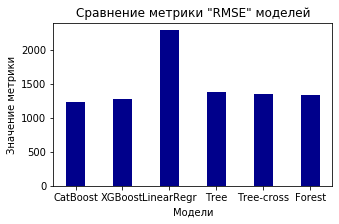

Наилучшее значение у модели CatBoost : 1231.607053344471



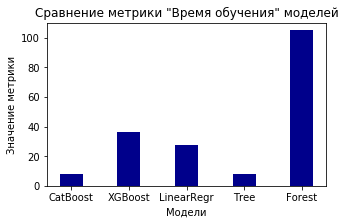

Наилучшее значение у модели CatBoost : 7.6864142417907715



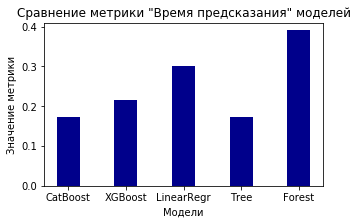

Наилучшее значение у модели CatBoost : 0.17240190505981445



In [56]:
rmse = (
    {'CatBoost': mean_absolute_error(target_test, predicted_catboost),
     'XGBoost': mean_absolute_error(target_test, preds_xgb),
     'LinearRegr': mean_absolute_error(target_test, predicted_LinReg),
     'Tree': mean_absolute_error(target_test, predicted_tree),
     'Tree-cross': mean_absolute_error(target_test, predicted_tree_cross),
     'Forest': mean_absolute_error(target_test, predicted_forest)}
)
time_fit = (
    {'CatBoost': time_fit_catboost,
     'XGBoost': time_fit_xgb,
     'LinearRegr': time_fit_LinReg,
     'Tree': time_fit_tree,
     'Forest': time_fit_forest}
)
time_predict = (
    {'CatBoost': time_predict_catboost,
     'XGBoost': time_predict_xgb,
     'LinearRegr': time_predict_LinReg,
     'Tree': time_predict_tree,
     'Forest': time_predict_forest}
)

metrics = {'RMSE': rmse, 'Время обучения': time_fit, 'Время предсказания': time_predict}

for metric in metrics:
    models = list(metrics[metric].keys())
    values = list(metrics[metric].values())
    fig = plt.figure(figsize = (5, 3))
    plt.bar(models, values, color ='darkblue', width = 0.4)
    plt.xlabel("Модели")
    plt.ylabel("Значение метрики")
    plt.title('Сравнение метрики "' + metric + '" моделей')
    plt.show()
    print('Наилучшее значение у модели', min(metrics[metric], key=metrics[metric].get), ':', min(metrics[metric].values()))
    print()

Модель библиотеки CatBoost на метрике показала себя наилучшим образом, при этом Решающее дерево не сильно отстало (особенно с GridSearch), а по времени отработало значительно быстрее.  
Наименьшее значение метрики RMSE у модели CatBoost, по времени обучения и предсказания на втором месте. Самая быстрая — модель Решающего дерева.
А вот случаный лес оказался очень "медленной" моделью при неплохой метрике RMSE.